In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "XXXXXXXX" # username from the json file
os.environ['KAGGLE_KEY'] = "XXXXXXXXXXXX" # Provide your key from the json file
!XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX # api copied from kaggle

 99% 737M/745M [00:05<00:00, 116MB/s]
100% 745M/745M [00:05<00:00, 138MB/s]


In [2]:
# Upload data and extract the contents
from zipfile import ZipFile

file_name = "/content/covid19-radiography-database.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import PrecisionAtRecall,Recall

In [5]:
#Model Analysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [6]:
from numpy.random import seed
seed(0)

In [7]:
tf.random.set_seed(0)

In [8]:
#covidData['image'] = covidData['path'].map(lambda x: np.asarray(Image.open(x).resize((75, 75))))

In [9]:
# Model Training 
path = '/content/COVID-19_Radiography_Dataset'
classes = ["COVID","Normal"]
num_classes = len(classes)
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)
#Training Dataset
train_gen = train_datagen.flow_from_directory(directory=path,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="grayscale")
#Validation Dataset
test_gen = test_datagen.flow_from_directory(directory=path,
                                            target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=False, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="grayscale")

Found 11047 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.


In [10]:
#using Sequential Model
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', padding='Same', input_shape=(224, 224, 1)))
model.add(BatchNormalization())

################

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#################

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

################

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Output 
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 112, 112, 64)     0         
 ooling2D)                                                       
                                                        

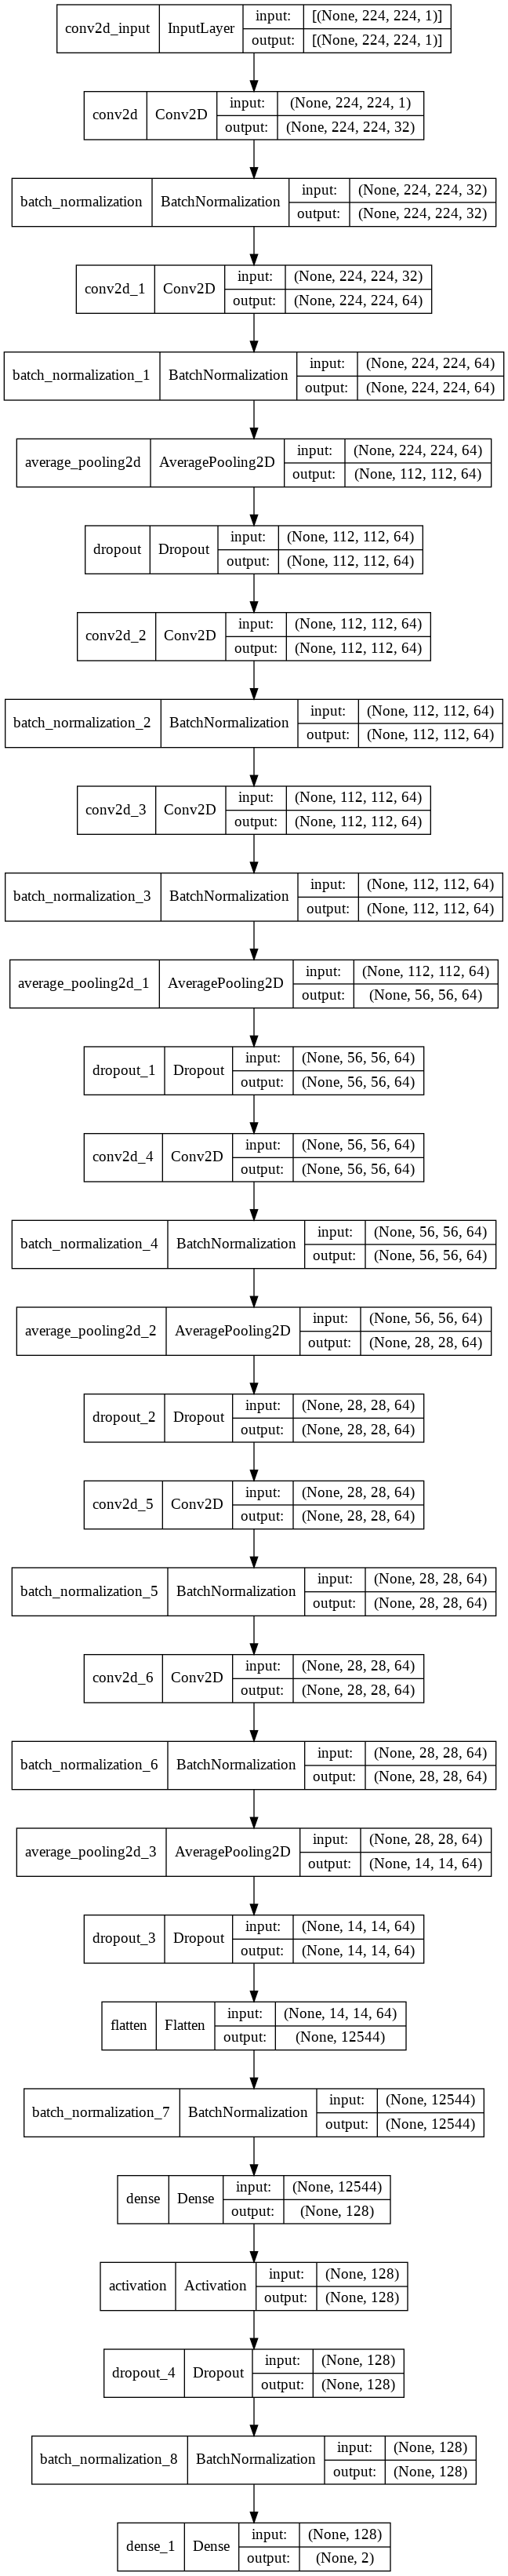

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
#compile Our Model
opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[Recall()])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
from PIL import Image, ImageOps
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size, grayscale=True)
    
    im2 = ImageOps.grayscale(img)
    
    #print(img.shape)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(im2)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            print(str(pred_index))
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    #print(grads)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [15]:
import numpy as np


In [16]:
img_array = get_img_array('/content/COVID-19_Radiography_Dataset/COVID/COVID-1000.png', size=(224, 224))
print(img_array.shape)

(1, 224, 224, 1)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [17]:
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_6')

tf.Tensor(1, shape=(), dtype=int64)


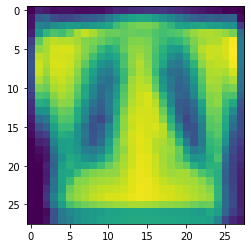

In [18]:
import matplotlib.pyplot as plt

plt.imshow(heatmap)

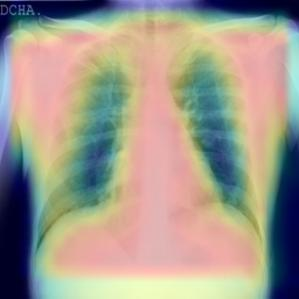

In [19]:
from IPython.display import Image, display
import matplotlib.cm as cm

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


#save_and_display_gradcam("/home/Data/train/Covid/COVID (13).png", heatmap)
save_and_display_gradcam('/content/COVID-19_Radiography_Dataset/COVID/COVID-1000.png', heatmap)


In [20]:
#Training Process
epochs=50

#callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=100, monitor='val_loss', mode='min')

callbacks_list = [learning_rate_reduction, early_stopping_monitor]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen) // batch_size,
                    validation_steps=len(test_gen) // batch_size,
                    validation_data=test_gen, epochs=epochs, callbacks=[callbacks_list])

Epoch 1/50
43/43 [==============================] - 13s 200ms/step - loss: 1.2238 - recall: 0.5538 - val_loss: 0.0194 - val_recall: 1.0000 - lr: 0.0020
Epoch 2/50
43/43 [==============================] - 8s 189ms/step - loss: 0.7564 - recall: 0.6468 - val_loss: 0.0122 - val_recall: 1.0000 - lr: 0.0020
Epoch 3/50
43/43 [==============================] - 8s 189ms/step - loss: 0.6530 - recall: 0.6715 - val_loss: 0.0206 - val_recall: 1.0000 - lr: 0.0020
Epoch 4/50
43/43 [==============================] - 8s 190ms/step - loss: 0.6320 - recall: 0.7006 - val_loss: 0.0194 - val_recall: 1.0000 - lr: 0.0020
Epoch 5/50
43/43 [==============================] - 8s 188ms/step - loss: 0.6142 - recall: 0.7108 - val_loss: 0.0590 - val_recall: 0.9812 - lr: 0.0020
Epoch 6/50
43/43 [==============================] - 8s 190ms/step - loss: 0.6254 - recall: 0.7093 - val_loss: 0.3593 - val_recall: 0.8250 - lr: 0.0020
Epoch 7/50
43/43 [==============================] - 11s 263ms/step - loss: 0.6222 - recall: 0

In [21]:
#prediction
y_pred =model.predict(test_gen)

In [22]:
import seaborn as sns
import pandas as pd

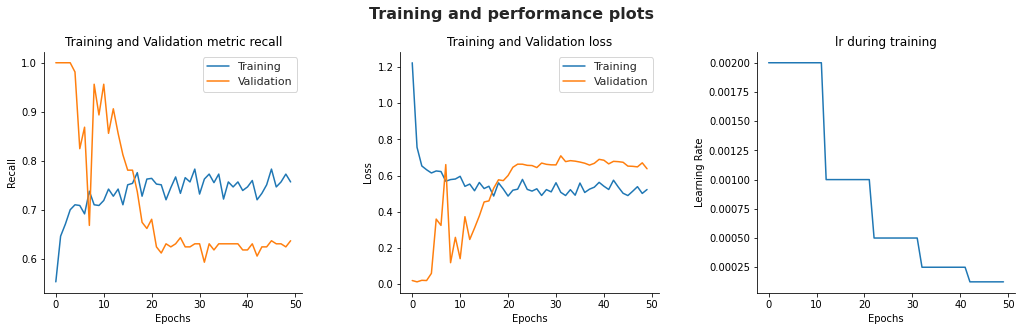

In [23]:

fig, axarr = plt.subplots(1,3, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['recall'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_recall'], ax=axarr[0], label="Validation");
ax.set_ylabel('Recall')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')
ax = sns.lineplot(x = historyDF.index, y = history.history['lr'], ax=axarr[2]);
ax.set_ylabel('Learning Rate')

axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')
axarr[2].set_title('lr during training')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

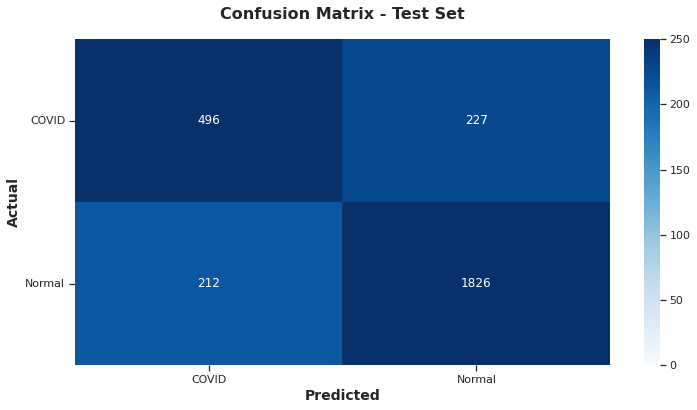

In [24]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [25]:
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model.predict(test_gen)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(y_pred)
print(test_gen.classes)
print(confusion_matrix(test_gen.classes, y_pred))
print('Classification Report')
target_names = ['COVID', 'Normal']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

[[0.9508927  0.04910731]
 [0.98066574 0.01933428]
 [0.14797676 0.8520233 ]
 ...
 [0.05283543 0.9471646 ]
 [0.10732611 0.89267385]
 [0.0148822  0.9851178 ]]
Confusion Matrix
[0 0 1 ... 1 1 1]
[0 0 0 ... 1 1 1]
[[ 496  227]
 [ 212 1826]]
Classification Report
              precision    recall  f1-score   support

       COVID       0.70      0.69      0.69       723
      Normal       0.89      0.90      0.89      2038

    accuracy                           0.84      2761
   macro avg       0.79      0.79      0.79      2761
weighted avg       0.84      0.84      0.84      2761



**Overall Results**
Accuracy Result: 84.10%
Precision Result: 79.50%
Recall Result: 79.10%
F-Score Result: 79.30%


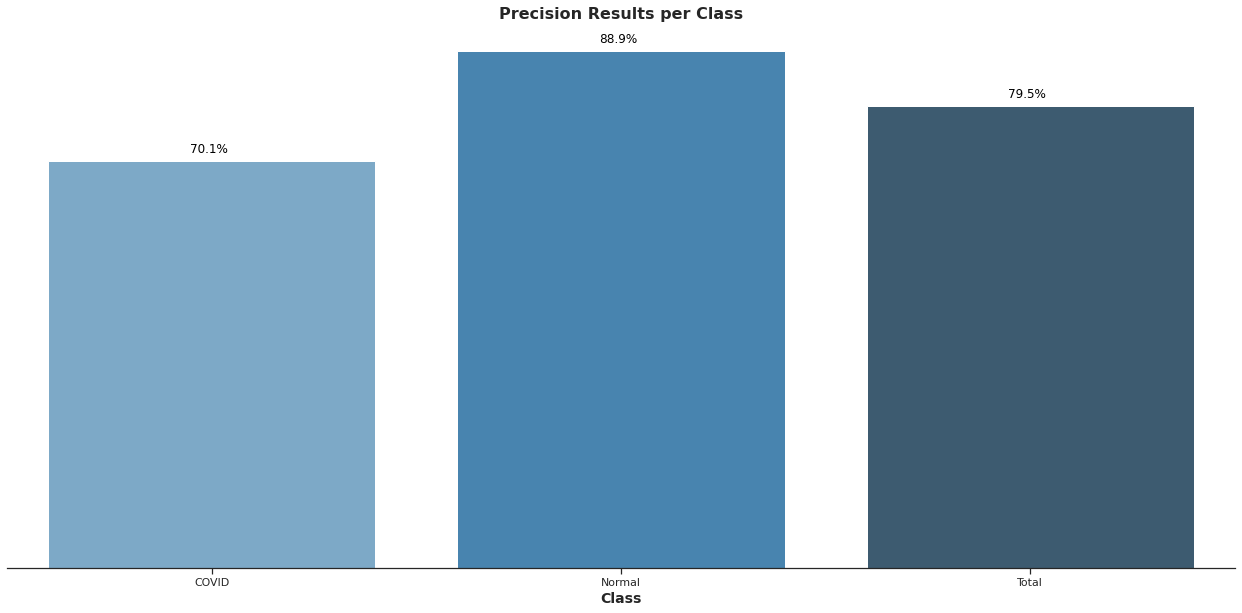

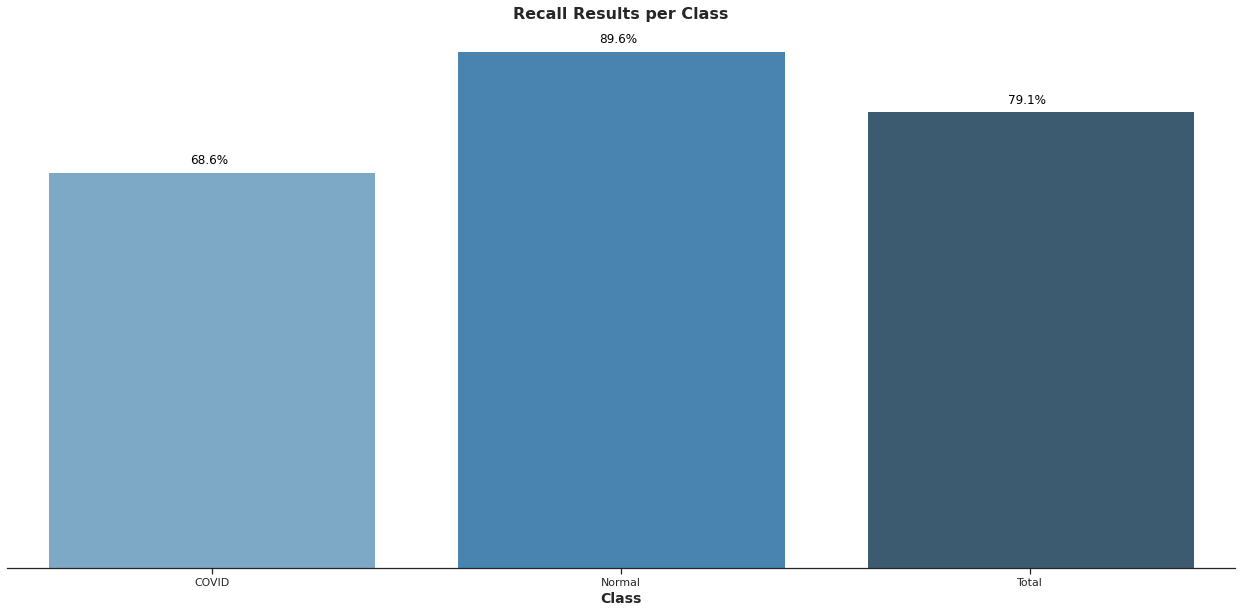

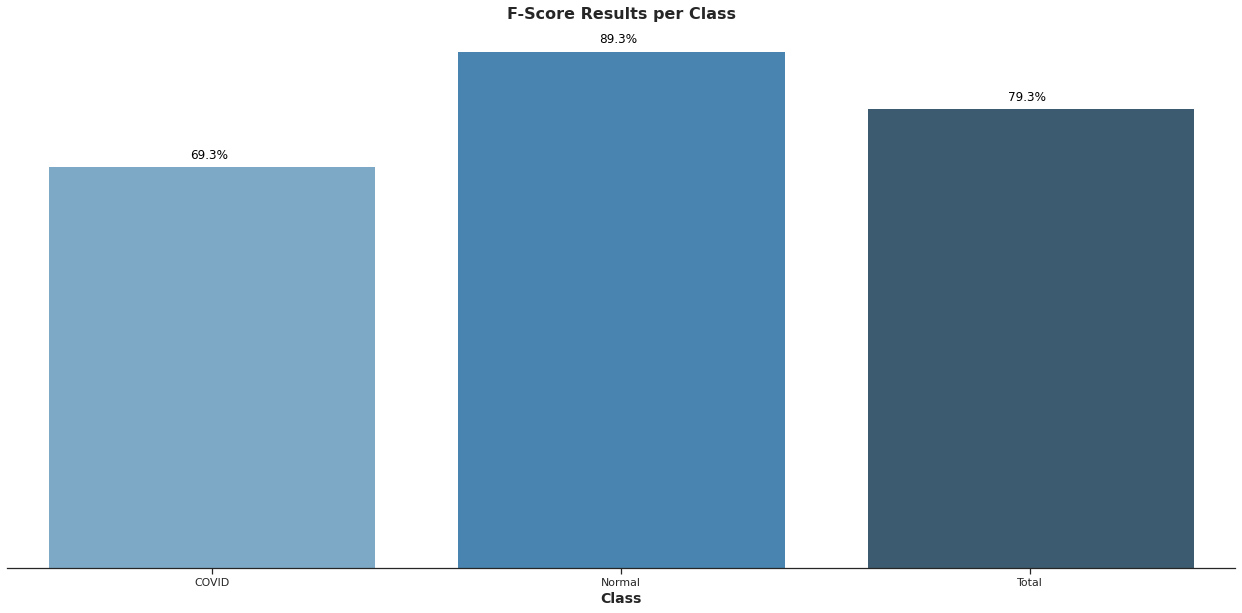

In [26]:
acc = accuracy_score(y_true, predictions)

results_all = precision_recall_fscore_support(y_true, predictions, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division=1)

metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID', 'Normal','Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');

metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))